# Previsualizador de Imagenes
  
En este notebook 
>- visualizador de imagenes  
>- Generador (flow_from_directory)
>- Generador con patches


### Previsualizando las Imagenes

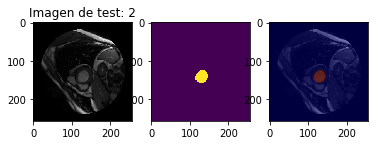

In [3]:
import keras
import matplotlib.pyplot as plt
import skimage.io as io
import os
import numpy as np
# Paths a los datos descargados


TRAIN_DATA_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Train/"
VAL_DATA_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Val/"
TEST_IMAGES_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Test/Images/"
TEST_LABELS_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Test/Labels/"

def visualizarImagenTest(imgNbr):
  # Leer el ground truth
    gt = io.imread(os.path.join(TEST_LABELS_DIR, str(imgNbr) + ".png"),as_gray = True)
    gt = gt[:,:].astype(np.bool).astype(np.float)

    # Leer la imagen original
    img = io.imread(os.path.join(TEST_IMAGES_DIR, str(imgNbr) + ".png"),as_gray = True)

    # Visualizar la imagen y el ground truth
    plt.figure()

    plt.subplot(1,3,1)
    plt.grid(False)
    plt.title("Imagen de test: " + str(imgNbr))

    plt.imshow(img, cmap='gray')

    plt.subplot(1,3,2)
    plt.grid(False)

    plt.imshow(gt, cmap = 'viridis')

    plt.subplot(1,3,3)
    plt.grid(False)
    #plt.hold(True)

    plt.imshow(img, cmap='gray')
    plt.imshow(gt, cmap='jet', alpha = 0.5)

visualizarImagenTest(2)

# Image Generator

In [9]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.transform as trans
import os

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def adjustData(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

def trainGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

def valGenerator(batch_size, train_path, image_folder, mask_folder, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)
        
def testGenerator(test_path,num_image = 30, target_size = (256,256), as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,str(i) + ".png"),as_gray = as_gray)
        img = img / 255.
        img = img[:,:,0]
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img
        
def saveResult(save_path,npyfile):
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [12]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGenerator = trainGenerator(20,
                             TRAIN_DATA_DIR,
                             'image',
                             'label',
                             data_gen_args,
                             save_to_dir = "data/membrane/train/aug")

myGenerator = trainGenerator(20,
                             TRAIN_DATA_DIR,
                             'image',
                             'label',
                             data_gen_args,
                             save_to_dir = None)

In [44]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

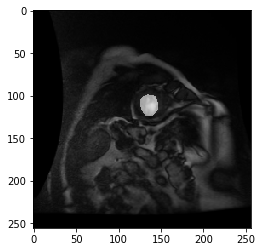

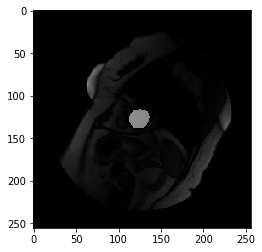

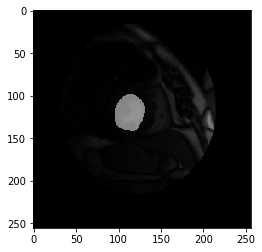

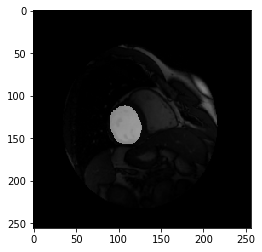

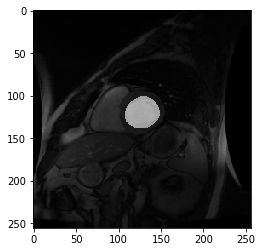

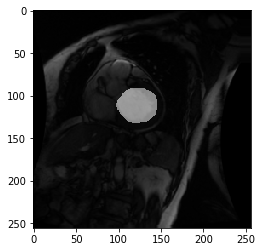

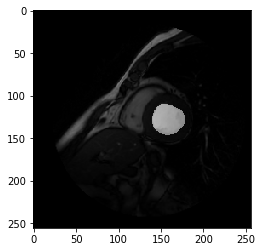

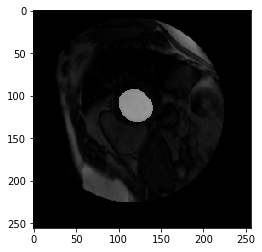

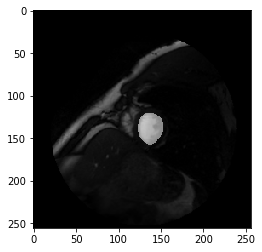

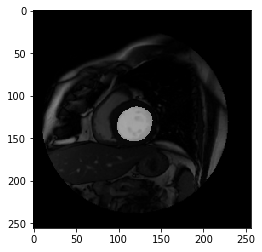

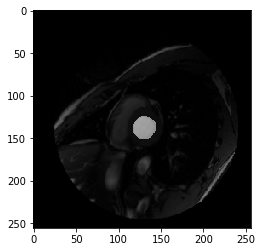

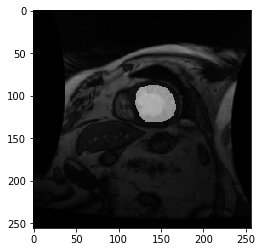

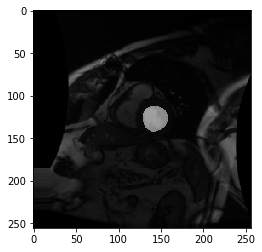

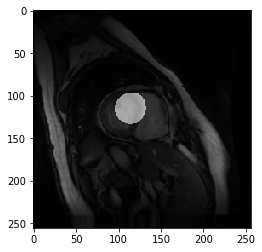

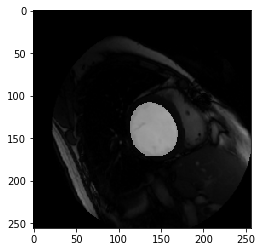

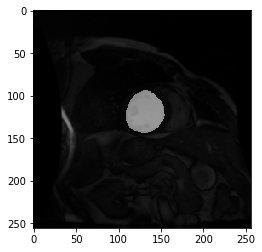

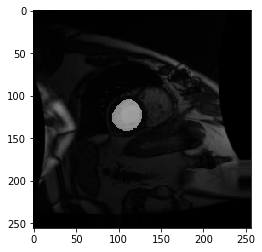

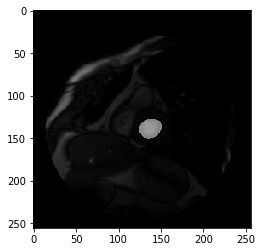

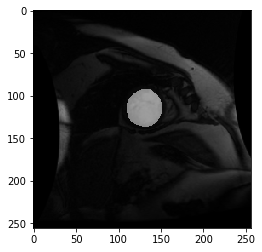

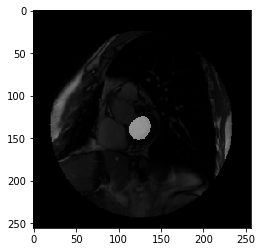

In [46]:
for i in range(batch[0].shape[0]):
    plt.imshow(batch[1][i][:,:,0], cmap='gray')
    plt.imshow(batch[0][i][:,:,0], cmap='gray',alpha=0.5)
    plt.show()


## Image Generator with Patches

In [97]:
#tomado de https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, mask, random_crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3 
    
    height, width = img.shape[1], img.shape[2]
    
    #dy y dx son las dimensiones del patche
    dy, dx = random_crop_size

    #x e y son el punto de inicio del patche
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    print(img.shape)
    
    image_patch = img[:, y:(y+dy), x:(x+dx), :]
    mask_patch = mask[:, y:(y+dy), x:(x+dx), :]
    return (image_patch, mask_patch)


In [98]:
def trainGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img, mask = random_crop(img, mask, (100, 100))
        img,mask = adjustData(img,mask)
        yield (img,mask)

In [99]:
myGenerator = trainGenerator(20,
                             TRAIN_DATA_DIR,
                             'image',
                             'label',
                             data_gen_args,
                             save_to_dir = None)

#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 1
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 470 images belonging to 1 classes.
Found 470 images belonging to 1 classes.
(20, 256, 256, 1)
(20, 256, 256, 1)


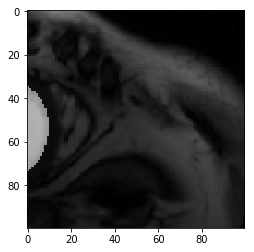

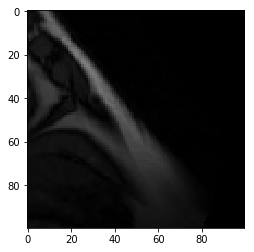

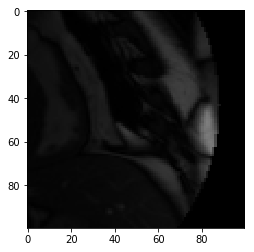

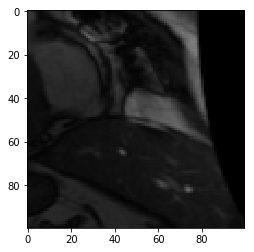

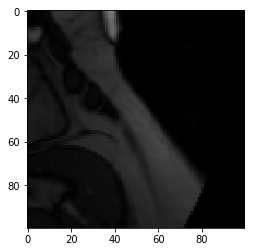

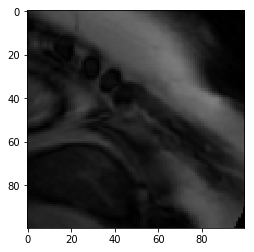

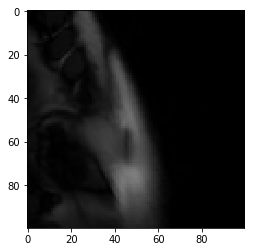

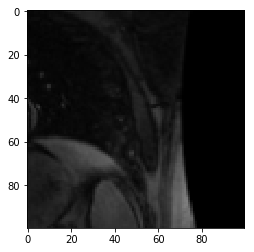

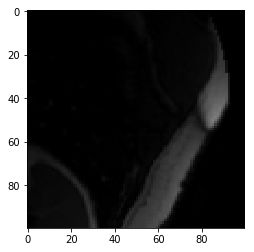

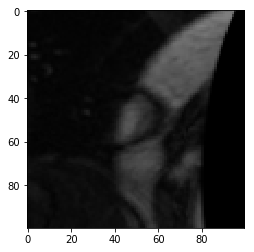

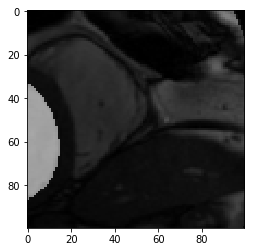

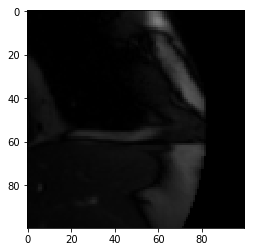

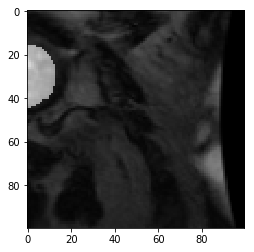

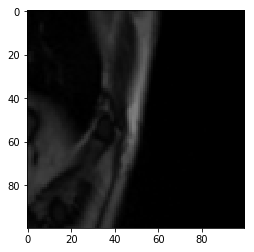

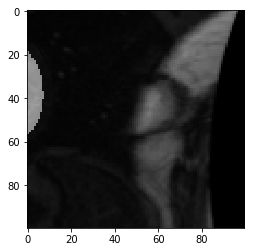

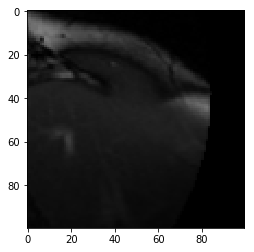

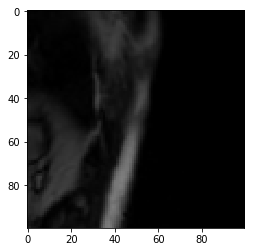

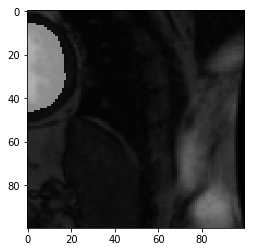

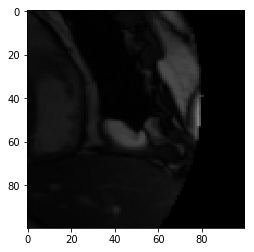

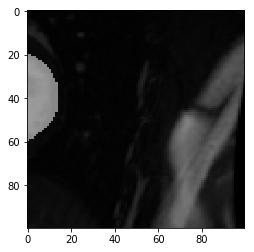

In [100]:
for i in range(batch[0].shape[0]):
    plt.imshow(batch[1][i][:,:,0], cmap='gray')
    plt.imshow(batch[0][i][:,:,0], cmap='gray',alpha=0.5)
    plt.show()